In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_theme()

In [3]:
df = pd.read_csv('data/main-processed.tsv', sep='\t')
df['log_tc'] = df['tc'].apply(lambda x: np.log(x))

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.metrics import mean_absolute_error

import category_encoders as ce

In [5]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

In [6]:
partitions = []

idxs = np.linspace(0, len(df), 17, dtype=int)
for st, ed in zip(idxs, idxs[1:]):
    partitions.append(df.iloc[st:ed].copy())

In [7]:
pl = Pipeline([
('ct', ColumnTransformer([
    ('impute', SimpleImputer(strategy='median'), ['yoe_total']),
    #('onehot', OneHotEncoder(min_frequency=10, handle_unknown='infrequent_if_exist'), ['company', 'location', 'level_name']),
    ('target', ce.TargetEncoder(), ['company', 'location', 'level_name']),
], remainder='drop')),
('reg', LinearRegression())
])

In [8]:
from collections import defaultdict
import matplotlib.gridspec as gridspec


In [9]:
def continuous_demo_dist(X, pl, A='gender', steps = 100, filter_location=None):
    results = defaultdict(list)

    X = X.copy()
    if filter_location:
        X = X[X['location'] == filter_location]
    X['predicted'] = pl.predict(X)
    bins = np.linspace(X['predicted'].min(), X['predicted'].max(), steps)

    for v in X[A].unique():
        results[v] = [(X[X[A] == v]['predicted'] > y_bin).mean() for y_bin in bins]
    results['bins'] = bins
    return np.subtract(results['Male'], results['Female']).sum() / 100

In [15]:
#p_vals = [0, 0.3, 0.5, 0.7, 0.9] # Probability to 'agree on salary' - replace what is seen in data with model prediction
#s_vals = [0, 0.3, 0.5, 0.7, 0.9] # Magniutde of noise added to predictions
p_vals = [0, 0.5, 0.7]
s_vals = [0, 0.3, 0.9]
results = {}
for p in p_vals:
    results[p] = {}
    p_dict = results[p]
    for s in s_vals:
        p_dict[s] = defaultdict(list)
        s_dict = p_dict[s]
        for i in range(len(partitions)):
            
            if i > 0:
                cur = pd.concat([partitions[i-1], partitions[i]])
            else:
                cur = partitions[i]
            X = cur.drop(['tc', 'base', 'stock', 'bonus', 'log_tc'], axis=1)
            y = cur['log_tc']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
            
            pl.fit(X_train, y_train)
            r2 = pl.score(X_test, y_test)
            mae = mean_absolute_error(y_test, pl.predict(X_test))
            dist = continuous_demo_dist(X, pl)
            dist_sf = continuous_demo_dist(X, pl, filter_location='San Francisco, CA')
            if i > 0:
                s_dict['r2'].append(r2)
                s_dict['mae'].append(mae)
                s_dict['dp_dist'].append(dist)
                s_dict['dp_dist_sf'].append(dist_sf)
            #print(f"Partition {i}: R2 = {r2}, MAE = {mae}")
            
            if i+1 < len(partitions):
                #Predict with current model
                nxt = partitions[i+1]
                nxt['rand'] = np.random.rand(len(nxt))
                nxt['preds'] = pl.predict(nxt.drop(['tc', 'base', 'stock', 'bonus', 'log_tc'], axis=1))
                
                #Add noise
                std = nxt['log_tc'].std()
                nxt['noise'] = np.random.normal(0, s*std, len(nxt))
                
                nxt.loc[nxt['rand'] < p, 'log_tc'] = nxt.loc[nxt['rand'] < p, 'preds'] + nxt.loc[nxt['rand'] < p, 'noise']

C:\Users\Lily\AppData\Local\Temp\ipykernel_22100\3071501665.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=-1)


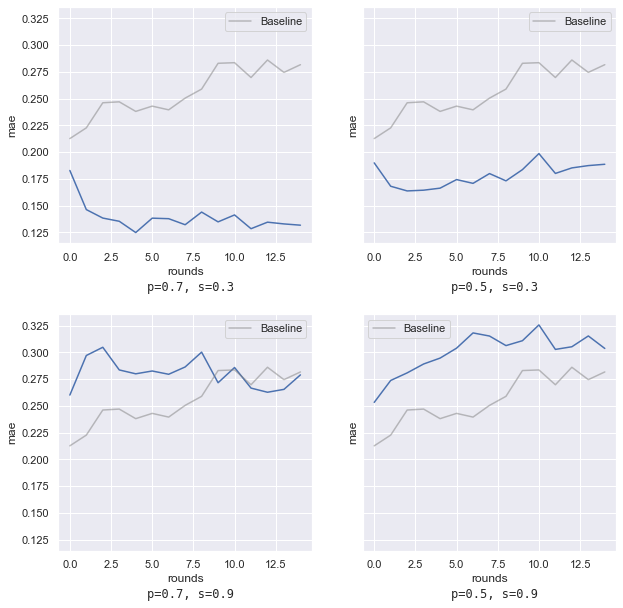

In [11]:
plot_vals = [(0.7, 0.3), (0.5, 0.3), (0.7, 0.9), (0.5, 0.9)]
fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'hspace': 0.3}, sharey=True)

for i, ps in enumerate(plot_vals):
    p, s = ps
    ax_i = ax[i // 2, i % 2]
    data = results[p][s]['mae']
    ax_i.plot(data)
    ax_i.plot(results[0][0.3]['mae'], color='grey', alpha=0.5, label='Baseline')
    ax_i.legend()
    ax_i.set_ylabel("mae")
    ax_i.set_xlabel("rounds")
    #ax_i.plot(s_dict['r2'], label=f"p={p}, s={s}")
    ax_i.text(0.35, -0.2, f"p={p}, s={s}", transform=ax_i.transAxes, fontfamily='monospace')

plt.tight_layout(h_pad=-1)
plt.savefig('./vis/dsc-167-2/feedback_loop.png', bbox_inches='tight')

C:\Users\Lily\AppData\Local\Temp\ipykernel_22100\4227902598.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=-1)


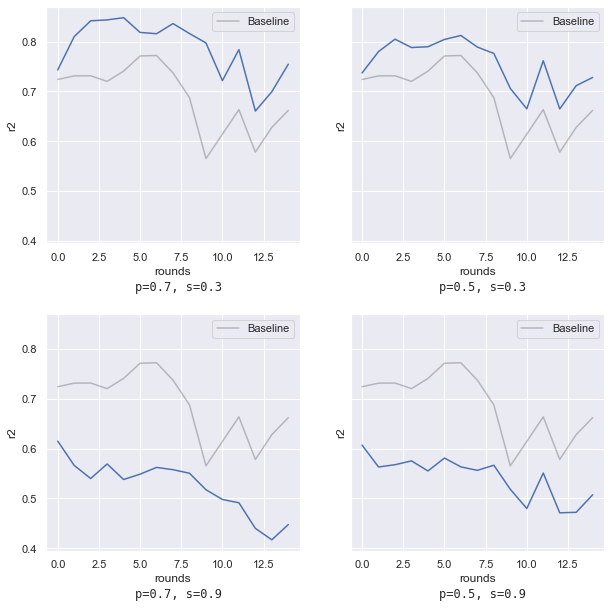

In [12]:
plot_vals = [(0.7, 0.3), (0.5, 0.3), (0.7, 0.9), (0.5, 0.9)]
fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'hspace': 0.3}, sharey=True)

for i, ps in enumerate(plot_vals):
    p, s = ps
    ax_i = ax[i // 2, i % 2]
    data = results[p][s]['r2']
    ax_i.plot(data)
    ax_i.plot(results[0][0.3]['r2'], color='grey', alpha=0.5, label='Baseline')
    ax_i.legend()
    ax_i.set_ylabel("r2")
    ax_i.set_xlabel("rounds")
    #ax_i.plot(s_dict['r2'], label=f"p={p}, s={s}")
    ax_i.text(0.35, -0.2, f"p={p}, s={s}", transform=ax_i.transAxes, fontfamily='monospace')

plt.tight_layout(h_pad=-1)
plt.savefig('./vis/dsc-167-2/feedback_loop_r2.png', bbox_inches='tight')

C:\Users\Lily\AppData\Local\Temp\ipykernel_22100\289545272.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=-1)


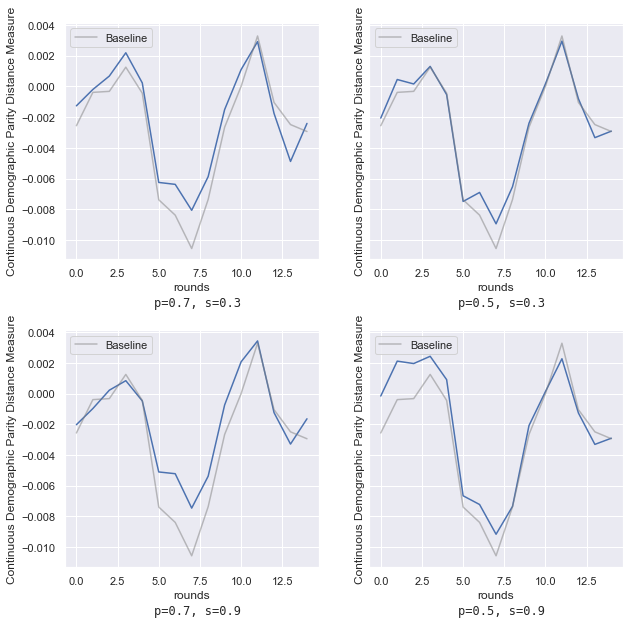

In [17]:
plot_vals = [(0.7, 0.3), (0.5, 0.3), (0.7, 0.9), (0.5, 0.9)]
fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'hspace': 0.3}, sharey=True)

for i, ps in enumerate(plot_vals):
    p, s = ps
    ax_i = ax[i // 2, i % 2]
    data = results[p][s]['dp_dist']
    ax_i.plot(data)
    ax_i.plot(results[0][0.3]['dp_dist'], color='grey', alpha=0.5, label='Baseline')
    ax_i.legend()
    ax_i.set_ylabel("Continuous Demographic Parity Distance Measure")
    ax_i.set_xlabel("rounds")
    #ax_i.plot(s_dict['dp_dist'], label=f"p={p}, s={s}")
    ax_i.text(0.35, -0.2, f"p={p}, s={s}", transform=ax_i.transAxes, fontfamily='monospace')

plt.tight_layout(h_pad=-1)
plt.savefig('./vis/dsc-167-2/feedback_loop_dp_dist.png', bbox_inches='tight')

C:\Users\Lily\AppData\Local\Temp\ipykernel_22100\2932324220.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad=-1)


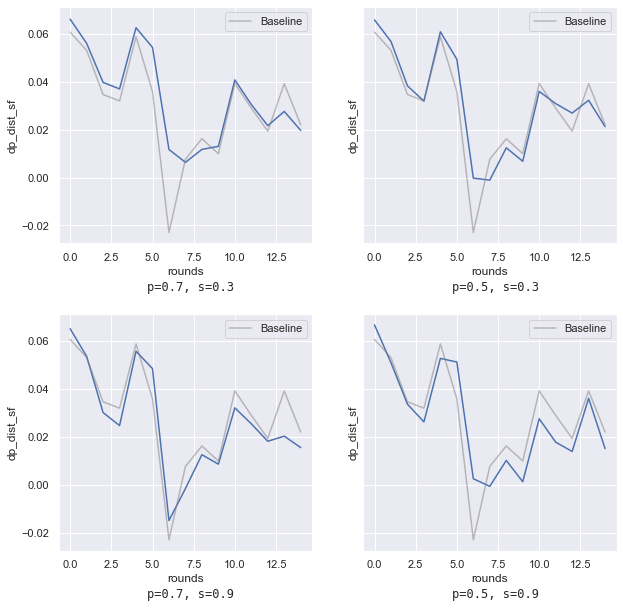

In [16]:
plot_vals = [(0.7, 0.3), (0.5, 0.3), (0.7, 0.9), (0.5, 0.9)]
fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'hspace': 0.3}, sharey=True)

for i, ps in enumerate(plot_vals):
    p, s = ps
    ax_i = ax[i // 2, i % 2]
    data = results[p][s]['dp_dist_sf']
    ax_i.plot(data)
    ax_i.plot(results[0][0.3]['dp_dist_sf'], color='grey', alpha=0.5, label='Baseline')
    ax_i.legend()
    ax_i.set_ylabel("dp_dist_sf")
    ax_i.set_xlabel("rounds")
    #ax_i.plot(s_dict['dp_dist_sf'], label=f"p={p}, s={s}")
    ax_i.text(0.35, -0.2, f"p={p}, s={s}", transform=ax_i.transAxes, fontfamily='monospace')

plt.tight_layout(h_pad=-1)
plt.savefig('./vis/dsc-167-2/feedback_loop_dp_dist_sf.png', bbox_inches='tight')

In [14]:
model_dict = {'lr': {}}
params_dict = {'train_size': 0.3}